# Trabalho 04 - Resistência dos Materiais MAC015 - Turma X 2024.3
___

- Ana Beatriz Lana Maciel Moreira Armond (202165501B)
- Gabriella Cruz e Silva (202165512B)

In [ ]:
# Importando Bibliotecas
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from IPython.display import display

Desenvolva uma rotina computacional para calcular a inclinação e deflexão de vigas isostáticas.

* Considere os seguintes modelos estruturais: viga simplesmente apoiada, engastada e livre
e biapoiada com balanço.
* Considere, no mínimo, os seguintes tipos de carregamento: concentrado, uniformemente distribuído, linear e carga momento, inclusive a combinação simultânea de todos eles.
* Considere diferentes tipos de seção transversal.
* Arbitrar o material.
* Plotar as curvas $θ(x)$ e $v(x)$.

## Relatório da Atividade

Foram aproveitadas as rotinas das atividades anteriores, adicionando carga momento e testando novos tipos de vigas. Para cada exemplo, são representados os diagramas de cortante $V(x)$, momento fletor $M(x)$, inclinação $θ(x)$ e deflexão $v(x)$, além de demais informações calculadas na viga e na sua seção transversal.

## Bibliotecas Utilizadas

- **SymPy**: Para cálculos simbólicos (integração, diferenciação, resolução de equações).
- **NumPy**: Para operações numéricas e geração de arrays.
- **Matplotlib**: Para visualização gráfica.
- **IPython**: Para exibição de resultados no ambiente Jupyter Notebook.

## Estrutura do Código

### 1. **Classe `Rectangle`**
   - Representa um retângulo com propriedades como largura, altura, posição do centro e área.
   - Métodos:
     - `moment_of_inertia_x()`: Calcula o momento de inércia em torno do eixo X.
     - `moment_of_inertia_y()`: Calcula o momento de inércia em torno do eixo Y.
     - `product_of_inertia()`: Calcula o produto de inércia.

### 2. **Classe `CompositeSection`**
   - Representa uma seção composta por vários retângulos.
   - Métodos:
     - `calculate_centroid_x()` e `calculate_centroid_y()`: Calculam o centroide da seção.
     - `moment_of_inertia_x()` e `moment_of_inertia_y()`: Calculam os momentos de inércia da seção composta.
     - `plot_section()`: Plota a seção transversal com zonas de tensão e compressão.

### 3. **Classe `Support`**
   - Representa os apoios da viga, com restrições nos eixos X, Y e momento.
   - Métodos:
     - `__repr__()`: Retorna uma representação textual do apoio.

### 4. **Classe `Force`**
   - Representa uma força aplicada na viga.
   - Métodos:
     - `force_moment`: Calcula o momento gerado pela força.
     - `__repr__()`: Retorna uma representação textual da força.

### 5. **Classe `Load` (e subclasses `ConstantLoad` e `LinearLoad`)**
   - Representa carregamentos distribuídos na viga.
   - Métodos:
     - `total_force_y()`: Calcula a força total vertical.
     - `total_moment()`: Calcula o momento total gerado pelo carregamento.
     - `shear_function()`: Calcula a função cortante.

### 6. **Classe `MomentLoad` **
   - Representa  as cargas momento, sendo no sentido anti-horário positivo e no sentido horário negativo.
   - Métodos:
     - `__repr__()`: Retorna uma representação textual do momento.

### 7. **Classe `Beam`**
   - Representa a viga como um sistema completo, com forças, carregamentos, apoios e momentos.
   - Métodos:
     - `calculate_support_reactions()`: Calcula as reações nos apoios.
     - `shear_force()`: Calcula a força cortante ao longo da viga.
     - `bending_moment()`: Calcula o momento fletor ao longo da viga.
     - `analyze()`: Realiza a análise completa da viga.
     - `calculate_max_stresses()`: Calcula as tensões máximas na seção transversal.
     - `calculate_slope_deflection()`: Calcula a inclinação e a deflexão da viga.

### 7. **Função `draw_beam()`**
   - Plota a viga com seus elementos (apoios, forças, carregamentos e momentos).

### 8. **Função `plot_analysis()`**
   - Plota gráficos de análise (força cortante, momento fletor, etc.).

## Funcionalidades Principais - Vigas Isostáticas

1. **Cálculo de Reações de Apoio**:
   - Nosso código resolve equações de equilíbrio para determinar as reações nos apoios.

2. **Análise de Força Cortante e Momento Fletor**:
   - Calcula a força cortante e o momento fletor ao longo da viga, considerando carregamentos distribuídos e forças pontuais.

3. **Cálculo de Tensões Máximas**:
   - Determina as tensões de compressão e tração máximas na seção transversal.

4. **Cálculo de Deformações**:
   - Calcula a inclinação e a deflexão da viga usando integração simbólica.

5. **Visualização Gráfica**:
   - Plota a viga com seus elementos e gráficos de análise.

In [ ]:
# Classe que representa um retângulo com algumas propriedades, como largura, altura e posição
class Rectangle:
    def __init__(self, width, height, x_center, y_center, negative=False):
        self.width = width  # Largura do retângulo
        self.height = height  # Altura do retângulo
        self.x_center = x_center  # Posição X do centro
        self.y_center = y_center  # Posição Y do centro
        self.area = width * height  # Área do retângulo
        self.negative = negative  # Indica se o retângulo é "negativo" (por exemplo, um recorte na seção)

    # Cálculo do momento de inércia em torno do eixo X (momento de inércia para um retângulo)
    def moment_of_inertia_x(self):
        return (self.width * self.height**3) / 12

    # Cálculo do momento de inércia em torno do eixo Y (momento de inércia para um retângulo)
    def moment_of_inertia_y(self):
        return (self.height * self.width**3) / 12

    # Cálculo do produto de inércia (momento de inércia misto)
    def product_of_inertia(self):
        return (self.width**2 * self.height**2) / 12

# Classe para representar uma seção composta por vários retângulos
class CompositeSection:
    def __init__(self, rectangles):
        self.rectangles = rectangles  # Lista de retângulos que compõem a seção
        # Calcula o centroide da seção (média ponderada das posições dos centros dos retângulos)
        self.x_centroid = self.calculate_centroid_x()
        self.y_centroid = self.calculate_centroid_y()

    # Cálculo do centroide no eixo X da seção composta
    def calculate_centroid_x(self):
        sum_moments = sum(r.x_center * r.area for r in self.rectangles)  # Soma dos momentos em X
        sum_areas = sum(r.area for r in self.rectangles)  # Soma das áreas dos retângulos
        return sum_moments / sum_areas  # Centroide em X é a média ponderada das posições

    # Cálculo do centroide no eixo Y da seção composta
    def calculate_centroid_y(self):
        sum_moments = sum(r.y_center * r.area for r in self.rectangles)  # Soma dos momentos em Y
        sum_areas = sum(r.area for r in self.rectangles)  # Soma das áreas dos retângulos
        return sum_moments / sum_areas  # Centroide em Y é a média ponderada das posições

    # Cálculo do momento de inércia em torno do eixo X para a seção composta
    def moment_of_inertia_x(self):
        return sum((-1 if r.negative else 1)*(r.moment_of_inertia_x() + r.area * ((r.y_center - self.y_centroid) ** 2)) for r in self.rectangles)

    # Cálculo do momento de inércia em torno do eixo Y para a seção composta
    def moment_of_inertia_y(self):
        return sum((-1 if r.negative else 1)*(r.moment_of_inertia_y() + r.area * ((r.x_center - self.x_centroid) ** 2)) for r in self.rectangles)

    # Cálculo do produto de inércia (momento de inércia misto) para a seção composta
    def product_of_inertia(self):
        if len(self.rectangles) == 1:
          return 0  # Produto de inércia é zero para um único retângulo alinhado

        return sum((-1 if r.negative else 1) * (r.product_of_inertia() + r.area * (r.x_center - self.x_centroid) * (r.y_center - self.y_centroid)) for r in self.rectangles)

    def get_max_min_y(self):
        top_edges = [r.y_center + r.height/2 for r in self.rectangles]
        bottom_edges = [r.y_center - r.height/2 for r in self.rectangles]
        max_y = max(top_edges) if top_edges else 0
        min_y = min(bottom_edges) if bottom_edges else 0
        return max_y, min_y

    def get_y_top_bottom(self):
        max_y, min_y = self.get_max_min_y()
        y_top = max_y - self.y_centroid
        y_bottom = self.y_centroid - min_y
        return y_top, y_bottom

    def plot_section(self, bending_moment_sign=1, show_stress_zones=False):
        fig, ax = plt.subplots()
        for r in self.rectangles:
            x_bottom_left = r.x_center - r.width / 2
            y_bottom_left = r.y_center - r.height / 2
            color = 'white' if r.negative else 'gray'
            rect = plt.Rectangle((x_bottom_left, y_bottom_left), r.width, r.height,
                               facecolor=color, edgecolor='black', alpha=0.5)
            ax.add_patch(rect)
            plt.plot(r.x_center, r.y_center, 'ro')

        plt.plot(self.x_centroid, self.y_centroid, 'bo', label='Centróide')

        if show_stress_zones:
            x_left = min(r.x_center - r.width/2 for r in self.rectangles)
            x_right = max(r.x_center + r.width/2 for r in self.rectangles)
            max_y, min_y = self.get_max_min_y()

            if bending_moment_sign >= 0:
                top_color, bottom_color = 'pink', 'yellow'
                top_label, bottom_label = 'Compressão', 'Tensão'
            else:
                top_color, bottom_color = 'yellow', 'pink'
                top_label, bottom_label = 'Tensão', 'Compressão'

            ax.fill_betweenx([self.y_centroid, max_y], x_left, x_right,
                            color=top_color, alpha=0.3, label=top_label)
            ax.fill_betweenx([min_y, self.y_centroid], x_left, x_right,
                            color=bottom_color, alpha=0.3, label=bottom_label)
            ax.axhline(self.y_centroid, color='green', linestyle='--', label='Linha Neutra')

        plt.xlabel("X")
        plt.ylabel("Y")
        plt.grid()
        plt.axis("equal")
        plt.legend()
        plt.show()

# Classe que representa os apoios na viga, responsáveis por gerar reações
class Support:
    def __init__(self, rx, ry, rm, position, label):
        # Restrições nos eixos X, Y e momento
        self.rx = rx
        self.ry = ry
        self.rm = rm
        self.reactions = rx + ry + rm
        # Posição do apoio na viga
        self.position = position
        # Rótulo para identificação do apoio
        self.label = label

    # Representação do apoio, mostrando restrições e reações calculadas
    def __repr__(self):
        return (f"\nApoio {self.label}:\n"
                f"  Posição: {self.position}\n"
                f"  Restrições: Rx={self.rx}, Ry={self.ry}\n")

class Force:
  def __init__(self, magnitude, position, label):
    self.magnitude = magnitude
    self.position = position
    self.label = label

  @property
  def force_moment(self):
    return self.magnitude * self.position

  def __repr__(self):
      return (f"\nForça {self.label}:\n"
              f"   Magnitude: {self.magnitude}\n"
              f"   Posição: {self.position}\n")

# Classe base para carregamentos distribuídos (usada por cargas constantes e lineares)
class Load:
    def __init__(self, start, end, label):
        self.start = start          # Posição inicial do carregamento
        self.end = end              # Posição final do carregamento
        self.label = label          # Rótulo para identificação
        self.x = sp.symbols('x')    # Variável simbólica para integração

    @property
    # Retorna a função simplificada do carregamento
    def load_function(self):
        simplified_function = self.function.subs(self.variables)
        return simplified_function.subs({self.x: self.x - self.start}) if simplified_function.has(self.x) else simplified_function

    @property
    # Calcula a força total vertical como a integral do carregamento
    def total_force_y(self):
        return sp.integrate(self.load_function, (self.x, self.start, self.end))

    @property
    # Calcula o momento total gerado pelo carregamento
    def total_moment(self):
        return sp.integrate(self.load_function * self.x, (self.x, self.start, self.end))

    # Avalia a carga em um ponto específico
    def __call__(self, x):
        return self.load_function.subs({self.x: x})

    # Função cortante para carregamentos distribuídos
    def shear_function(self, x):
      w_at_point_x = self(x)
      wx = sp.integrate(sp.diff(self.function, self.x), self.x)
      aux = wx + w_at_point_x
      return sp.integrate(aux.subs(self.variables), self.x)

    # Representação do carregamento, mostrando ponto inicial e final
    def __repr__(self):
        return (f"\nCarregamento {self.label}:\n"
                f"  start: {self.start}\n"
                f"  end: {self.end}\n")

# Classe para carregamentos constantes
class ConstantLoad(Load):
    def __init__(self, start, end, label, intensity):
        self.intensity = intensity                      # Intensidade constante do carregamento
        self.variables = {sp.symbols('a'): intensity}   # Variável simbólica associada
        super().__init__(start, end, label)

    @property
    # Função constante do carregamento
    def function(self):
        return sp.symbols('a')

    # Adiciona a intensidade à representação do carregamento
    def __repr__(self):
        base_repr = super().__repr__()
        return base_repr + f"  Intensidade Constante: {self.intensity}\n"

# Classe para carregamentos lineares
class LinearLoad(Load):
    def __init__(self, start, end, label, start_intensity, end_intensity):
        # Intensidade no start do carregamento
        self.start_intensity = start_intensity
        # Intensidade no final do carregamento
        self.end_intensity = end_intensity
        # Cálculo da inclinação e do termo constante da função linear
        self.slope = (end_intensity - start_intensity) / (end - start)
        self.intercept = start_intensity
        self.variables = {
            sp.symbols('a'): self.slope,
            sp.symbols('b'): self.intercept
        }
        super().__init__(start, end, label)

    @property
    # Função linear que descreve o carregamento
    def function(self):
        return sp.symbols('a') * self.x + sp.symbols('b')

    # Adiciona as intensidades inicial e final à representação do carregamento
    def __repr__(self):
        base_repr = super().__repr__()
        return (base_repr +
                f"  Intensidade Inicial: {self.start_intensity}\n"
                f"  Intensidade Final: {self.end_intensity}\n")

class MomentLoad:
    def __init__(self, magnitude, position, label):
        self.magnitude = magnitude
        self.position = position
        self.label = label

    def __repr__(self):
        return (f"\nMomento {self.label}:\n"
                f"   Magnitude: {self.magnitude}\n"
                f"   Position: {self.position}\n")

# Classe para representar a viga como um sistema completo
class Beam:
    def __init__(self, length, forces=None, loads=None, moments=None, supports=None, E=None, section=None):
        self.length = length
        self.forces = forces if forces else []
        self.loads = loads if loads else []
        self.moments = moments if moments else []
        self.supports = supports if supports else []
        self.x = sp.symbols('x')
        self.E = E
        self.section = section

    def add_moment(self, moment):
        self.moments.append(moment)

    def total_moments(self):
        return sum(moment.magnitude for moment in self.moments)

    # Adiciona uma força à viga
    def add_force(self, force):
        self.forces.append(force)

    # Adiciona um carregamento à viga
    def add_load(self, load):
        self.loads.append(load)

    # Adiciona um apoio à viga
    def add_support(self, support):
        self.supports.append(support)

    # Soma das forças verticais dos carregamentos
    def total_vertical_forces(self):
        return sum(load.total_force_y for load in self.loads)

    # Soma dos momentos gerados por carregamentos
    def total_load_moments(self):
        return sum(load.total_moment for load in self.loads)

    # Soma das forças
    def total_forces(self):
        return sum(force.magnitude for force in self.forces)

    # Soma dos momentos das forças
    def total_force_moments(self):
        return sum(force.force_moment for force in self.forces)

    # Calcula as reações nos apoios com base no equilíbrio estático
    def calculate_support_reactions(self):
        total_fy = self.total_vertical_forces() + self.total_forces()
        total_m = (self.total_load_moments() +
                  self.total_force_moments() +
                  self.total_moments())

        # Criação de variáveis simbólicas para reações
        reaction_y_symbols = [sp.symbols(f"R_{support.label}y") for support in self.supports if support.ry]
        reaction_m_symbols = [sp.symbols(f"R_{support.label}m") for support in self.supports if support.rm]

        # Termos de momento gerados pelas reações verticais
        moment_terms = [sp.symbols(f"R_{support.label}y") * support.position for support in self.supports if support.ry]

        # Equações de equilíbrio (força e momento)
        eq_fy = sp.Eq(total_fy + sum(reaction_y_symbols), 0)
        eq_m = sp.Eq(total_m + sum(moment_terms) + sum(reaction_m_symbols), 0)

        # Resolução do sistema de equações
        solutions = sp.solve((eq_fy, eq_m), reaction_y_symbols + reaction_m_symbols)

        # Atualiza as reações calculadas nos apoios
        for support in self.supports:
            support.reaction_y = solutions.get(sp.symbols(f"R_{support.label}y"), 0)
            support.reaction_m = solutions.get(sp.symbols(f"R_{support.label}m"), 0)

        return solutions

    # Lista de Pontos de interesse
    def points(self):

      points = [force.position for force in self.forces] + \
               [moment.position for moment in self.moments] + \
               [load.start for load in self.loads] + \
               [load.end for load in self.loads] + \
               [support.position for support in self.supports]

      return sorted(list(set(points)))

    # Calcula a força cortante V(x)
    def shear_force(self, points):
        V_forces = []             # Lista para armazenar os valores da força cortante em cada trecho
        last_force_point = None   # Variável para armazenar a força cortante do último ponto avaliado
        x = sp.symbols('x')       # Define a variável simbólica 'x' para expressões simbólicas do SymPy
        last_end = None

        # Iteração pelos trechos da viga
        # Exemplo: se L = 10 -> [start, end] = [(0,2), (2,5), (5,10), (10,10)]
        if points[0] != 0:
          points = [0] + points

        if points[-1] != self.length:
          points = points + [self.length]

        for start, end in zip(points[:-1], points[1:]):

          distance = end - start
          # Filtra os carregamentos distribuídos que atuam no trecho analisado
          loads = [load for load in self.loads if load.start < end and load.end > start]
          # Filtra as forças pontuais aplicadas exatamente no start do trecho
          forces = [force.magnitude for force in self.forces if force.position == start]
          # Obtém as reações dos apoios que atuam no start do trecho
          reactions = [support.reaction_y for support in self.supports if support.position == start]

          shear_function = [load.shear_function(start) for load in loads]
          v = sum(forces) + sum(reactions) + sum(shear_function)

          if last_force_point is not None and last_end != 0  and start != self.length:
            v += last_force_point

          last_force_point = v.subs({x:distance}) if not type(v) == int and v.has(x) else v
          last_end = end
          V_forces.append({'F': v, 'start': start, 'end': end})

        V_forces.append({'F': 0, 'start':  self.length, 'end': self.length})

        return V_forces

    # Calcula o momento fletor M(x)
    def bending_moment(self, points, V):
      M_funcs = []                # Lista para armazenar as funções do momento fletor
      last_moment = None          # Último valor de momento no trecho anterior (inicialmente indefinido)
      x = sp.symbols('x')         # Variável simbólica para operações simbólicas
      last_end = None

      # Iteração pelos trechos da viga
      # Exemplo: se L = 10 -> [start, end] = [(0,2), (2,5), (5,10), (10,10)]
      if points[0] != 0:
          points = [0] + points

      if points[-1] != self.length:
        points = points + [self.length]

      for i, (start, end) in enumerate(zip(points[:-1], points[1:])):

        distance = end - start
        # Obtém as reações dos apoios
        reactions = [support.reaction_m for support in self.supports if support.position == start]
        moments = [m.magnitude for m in self.moments if m.position == start]

        shear_function = V[i]['F']
        M_f = sp.integrate(shear_function, x)
        m = M_f - sum(reactions) - sum(moments)

        if last_moment is not None and last_end != 0 and start != self.length:
          m += last_moment

        last_moment = m.subs({x:distance}) if not type(m) == int and m.has(x) else m
        M_funcs.append({'F': m, 'start': start, 'end': end})

      return M_funcs

    # Método principal para análise da viga
    def analyze(self):
      self.support_reactions = self.calculate_support_reactions()
      points = self.points()
      self.V = self.shear_force(points)
      self.M = self.bending_moment(points, self.V)

    def find_max_bending_moment(self):
        max_abs_moment = 0
        max_moment_info = None
        x = sp.symbols('x')

        for m_segment in self.M:
            start = m_segment['start']
            end = m_segment['end']
            func = m_segment['F']

            if start == end:
                continue

            if isinstance(func, (int, float)):
                current_max = abs(func)
                current_pos = start
                current_val = func
            else:
                x_vals = np.linspace(start, end, 100)
                func_lambda = sp.lambdify(x, func, 'numpy')
                m_vals = func_lambda(x_vals)

                if np.isscalar(m_vals):
                    m_vals = np.full_like(x_vals, m_vals)

                max_idx = np.argmax(np.abs(m_vals))
                current_max = abs(m_vals[max_idx])
                current_pos = x_vals[max_idx]
                current_val = m_vals[max_idx]

            if current_max > max_abs_moment:
                max_abs_moment = current_max
                max_moment_info = {'value': current_val, 'position': current_pos}

        return max_moment_info

    def calculate_max_stresses(self):
        if not self.section:
            raise ValueError("Sessão Transversal não Definida")

        moment_info = self.find_max_bending_moment()
        if not moment_info:
            return 0, 0, 0

        M = moment_info['value']
        pos = moment_info['position']
        I = self.section.moment_of_inertia_x()
        y_top, y_bottom = self.section.get_y_top_bottom()

        stress_top = M * y_top / I
        stress_bottom = -M * y_bottom / I

        if M > 0:
            max_compression = stress_top
            max_tension = abs(stress_bottom)
        else:
            max_tension = abs(stress_top)
            max_compression = abs(stress_bottom)

        return max_compression, max_tension, pos

    def calculate_slope_deflection(self):
      slopes = []
      deflections = []
      x = sp.symbols('x')
      last_d = 0
      last_i = 0
      points = self.points()
      EI = self.E * self.section.moment_of_inertia_x()
      support_count = 0

      if points[0] != 0:
          points = [0] + points

      if points[-1] != self.length:
        points = points + [self.length]

      C1s = []
      C2s = []
      eqs = []
      C_id = 1

      for i, (start, end) in enumerate(zip(points[:-1], points[1:])):
        C1s.append(sp.symbols(f"C{C_id}"))
        C2s.append(sp.symbols(f"C{C_id+1}"))
        C_id += 2

        f =  self.M[i]
        slope = sp.integrate(f['F']/EI, x) + C1s[i] + last_d
        deflection = sp.integrate(slope, x) + C2s[i] + last_i


        dist = end-start
        supports = [support for support in self.supports if start <= support.position <= end]

        for support in supports:

          if support.reactions == 3 and start == support.position:
            eqs.append(sp.Eq(deflection.subs(x, 0), 0))
            eqs.append(sp.Eq(slope.subs(x, 0), 0))
            break

          else:

            if support.position == end:
              eqs.append(sp.Eq(deflection.subs({x: dist}), 0))

            elif support.position == start:
              eqs.append(sp.Eq(deflection.subs({x: 0}), 0))


        if start != 0:
             eqs.append(sp.Eq(slope.subs({x: 0}), last_i))

        if start != 0 and all([s.position != start for s in supports]):
          eqs.append(sp.Eq(deflection.subs({x: 0}), last_d))


        d_current = deflection
        i_current = slope

        last_d = d_current.subs({x:dist}) if not type(d_current)==int and d_current.has(x) else d_current
        last_i = i_current.subs({x:dist}) if not type(i_current)==int and i_current.has(x) else i_current

        deflections.append({'F': deflection, 'start': start, 'end': end})
        slopes.append({'F': slope, 'start': start, 'end': end})

      sol = sp.solve(sp.Matrix(eqs), sp.Matrix(C1s+C2s))
      display(sp.Matrix(eqs), sp.Matrix(C1s+C2s), sol)

      for d in deflections:
        d['F'] = d['F'].subs(sol)

      for s in slopes:
        s['F'] = s['F'].subs(sol)

      self.theta = slopes
      self.v = deflections

    # Representação da viga com seus elementos
    def __repr__(self):
        return (f"\nViga:\n"
                f"  Comprimento: {self.length}\n"
                f"  Forças: {''.join(map(str, self.forces))}\n"
                f"  Carregamentos: {''.join(map(str, self.loads))}\n"
                f"  Apoios: {''.join(map(str, self.supports))}\n")

# Função para desenhar a viga e os elementos associados
def draw_beam(beam):
    fig, ax = plt.subplots(figsize=(14, 5))  # Increased figure height

    ax.plot([0, beam.length], [0, 0], color="black", linewidth=3, zorder=1)

    support_height = 0.8
    support_width = 0.5

    for support in beam.supports:
        x = support.position
        y_base = 0

        if support.rm:
            ax.add_patch(plt.Rectangle((x - support_width/2, y_base - support_height),
                                      support_width, support_height,
                                      facecolor='darkblue', zorder=2))
            ax.plot([x - support_width/2, x + support_width/2],
                   [y_base - support_height, y_base - support_height],
                   'k-', linewidth=2, zorder=3)

        elif support.rx == 0:
            roller_radius = support_height/4
            ax.add_patch(plt.Circle((x, y_base - roller_radius),
                        roller_radius,
                        facecolor='orange', edgecolor='k', zorder=2))

            for i in range(3):
                roller_x = x - support_width/2 + i*(support_width/2)
                ax.add_patch(plt.Circle((roller_x, y_base - roller_radius*2),
                            roller_radius/2,
                            facecolor='gray', edgecolor='k', zorder=2))

        else:
            pin_radius = support_height/4
            ax.add_patch(plt.Circle((x, y_base - pin_radius),
                        pin_radius,
                        facecolor='red', edgecolor='k', zorder=2))
            ax.plot([x, x], [y_base - pin_radius, y_base - pin_radius*3],
                   'k-', linewidth=2, zorder=3)

    for moment in beam.moments:
        x = moment.position
        arrow_style = dict(arrowstyle='simple,head_width=0.5',
                          color='purple',
                          lw=2,
                          connectionstyle=f"arc3,rad={0.25 * np.sign(moment.magnitude)}")
        ax.annotate('', xy=(x, 0.4),
                   xytext=(x - np.sign(moment.magnitude)*0.5, 0.4),
                   arrowprops=arrow_style, zorder=4)
        ax.text(x + 0.3, 0.45, f'M={moment.magnitude}',
               color='purple', fontsize=10, zorder=4)

    max_load_height = 0
    if beam.loads:
        max_intensity = max(
            max(abs(load.start_intensity), abs(load.end_intensity))
            if isinstance(load, LinearLoad) else abs(load.intensity)
            for load in beam.loads
        )

        for load in beam.loads:
            x = np.linspace(load.start, load.end, 100)

            if isinstance(load, LinearLoad):
                y = np.interp(x, [load.start, load.end],
                            [load.start_intensity, load.end_intensity])
            else:
                y = np.full_like(x, load.intensity)

            load_scale = 0.5 + (0.5 * (max_intensity / (max_intensity + 1000)))
            y_vis = load_scale * (-y / (max_intensity if max_intensity != 0 else 1))

            current_max = np.max(np.abs(y_vis))
            if current_max > max_load_height:
                max_load_height = current_max

            ax.fill_between(x, 0, y_vis,
                           color='green', alpha=0.4, zorder=2)
            ax.plot(x, y_vis, color='darkgreen', linewidth=1.5, zorder=3)

    for force in beam.forces:
        x = force.position
        if force.magnitude > 0:
            ax.arrow(x, 0.05, 0, 0.25,
                    head_width=0.3, head_length=0.1,
                    fc='blue', ec='blue', linewidth=2, zorder=4)
            ax.text(x + 0.3, 0.35, f'F=+{abs(force.magnitude)}',
                   color='blue', fontsize=10, va='bottom')
        else:
            ax.arrow(x, -0.05, 0, -0.25,
                    head_width=0.3, head_length=0.1,
                    fc='red', ec='red', linewidth=2, zorder=4)
            ax.text(x + 0.3, -0.35, f'F=-{abs(force.magnitude)}',
                   color='red', fontsize=10, va='top')

    ax.set_ylim(-support_height*1.5, 1)
    ax.set_aspect("equal")
    ax.axis("off")

    upper_lim = max(1.2, max_load_height * 1.2)
    lower_lim = -1.2 if any(f.magnitude < 0 for f in beam.forces) else -0.5
    ax.set_ylim(lower_lim, upper_lim)

    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Apoio de 2º Gênero',
               markerfacecolor='red', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Apoio de 1º Gênero',
               markerfacecolor='orange', markersize=10),
        Line2D([0], [0], marker='s', color='w', label='Apoio de 3º Gênero',
               markerfacecolor='darkblue', markersize=10),
        Line2D([0], [0], color='purple', lw=2, label='Carga Momento'),
        Line2D([0], [0], color='red', lw=2, label='Força para Baixo'),
        Line2D([0], [0], color='blue', lw=2, label='Força para Cima'),
        Patch(facecolor='green', alpha=0.3, label='Carregamento Distribuído')
    ]

    ax.legend(handles=legend_elements,
             loc='upper left',
             bbox_to_anchor=(1.02, 1),
             fontsize='small',
             frameon=False)

    plt.tight_layout()
    plt.show()

def plot_analysis(beam, funcs_list, title, color, invert=False):
    plt.figure(figsize=(8, 6))
    old_y = None
    x = sp.symbols('x')

    for i, func_dict in enumerate(funcs_list):
        func = func_dict['F']
        start = func_dict['start']
        end = func_dict['end']

        if start >= end:
            continue

        if isinstance(func, (int, float)):
            x_vals = np.array([start, end])
            y_vals = np.array([func, func])
        else:
            x_vals = np.linspace(start, end, 400)
            func_lambda = sp.lambdify(x, func, 'numpy')
            y_vals = func_lambda(x_vals - start)

            if np.isscalar(y_vals):
                y_vals = np.full_like(x_vals, y_vals)

        x_plot = np.linspace(start, end, len(y_vals))

        if old_y is not None and len(y_vals) > 0:
            plt.vlines(start, old_y, y_vals[0], color=color)

        plt.plot(x_plot, y_vals, color=color)
        old_y = y_vals[-1] if len(y_vals) > 0 else None

    if invert:
        plt.gca().invert_yaxis()

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.grid(True)
    plt.show()

___
# Definição das Seções Transversais

Foram selecionadas 3 tipos de seções também disponíveis no FTOOL para testar:

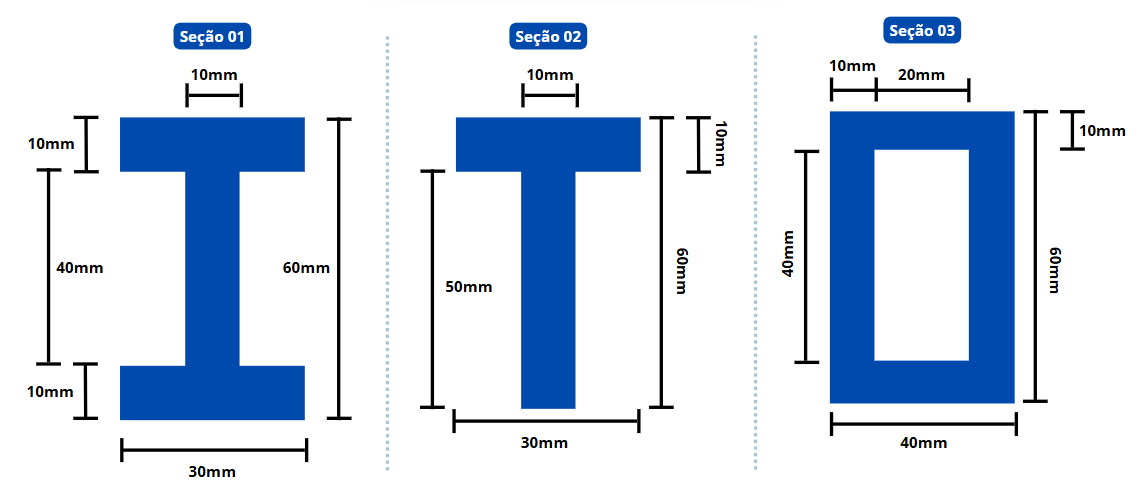

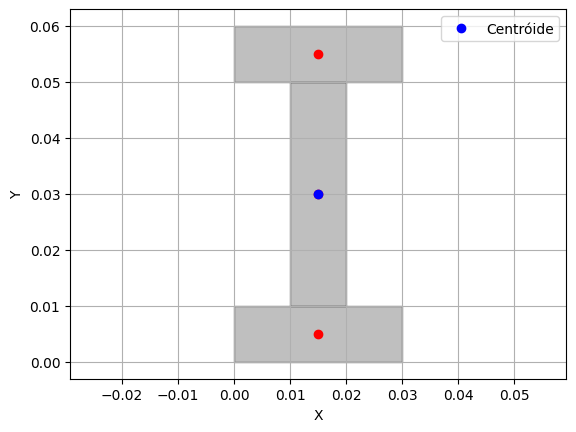

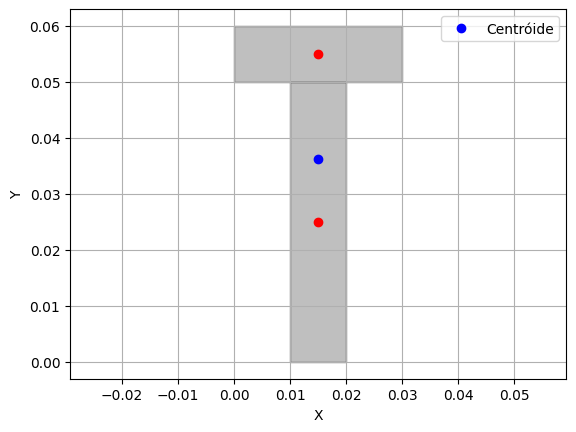

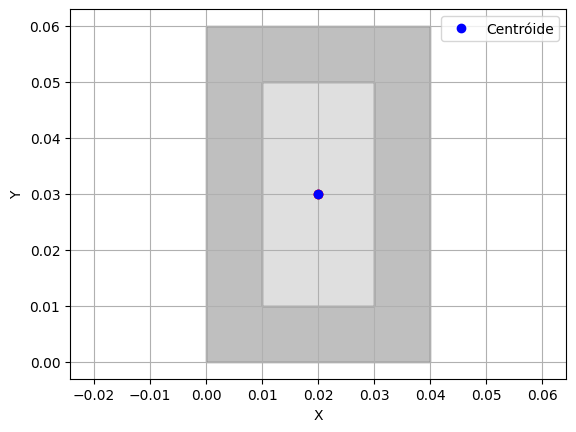

In [ ]:
# Definindo as Seções Transversais

# Seção 01
rect01 = Rectangle(0.030, 0.010, 0.015, 0.005)
rect02 = Rectangle(0.010, 0.040, 0.015, 0.030)
rect03 = Rectangle(0.030, 0.010, 0.015, 0.055)
section01 = CompositeSection([rect01, rect02, rect03])
section01.plot_section(bending_moment_sign=1, show_stress_zones=False)

# Seção 02
rect04 = Rectangle(0.030, 0.010, 0.015, 0.055)
rect05 = Rectangle(0.010, 0.050, 0.015, 0.025)
section02 = CompositeSection([rect04, rect05])
section02.plot_section(bending_moment_sign=1, show_stress_zones=False)

# Seção 03
rect06 = Rectangle(0.040, 0.060, 0.020, 0.030)
rect07 = Rectangle(0.020, 0.040, 0.020, 0.030, negative=True)
section03 = CompositeSection([rect06, rect07])
section03.plot_section(bending_moment_sign=1, show_stress_zones=False)

___
# Exemplo  01

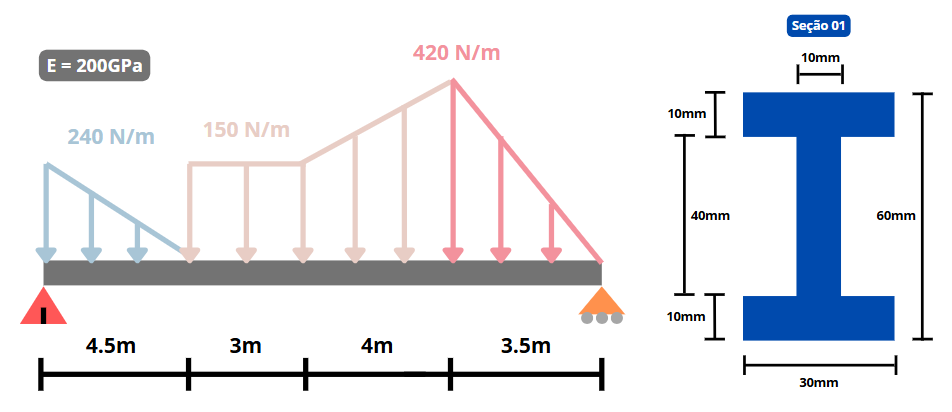

Solução pelo FTOOL:
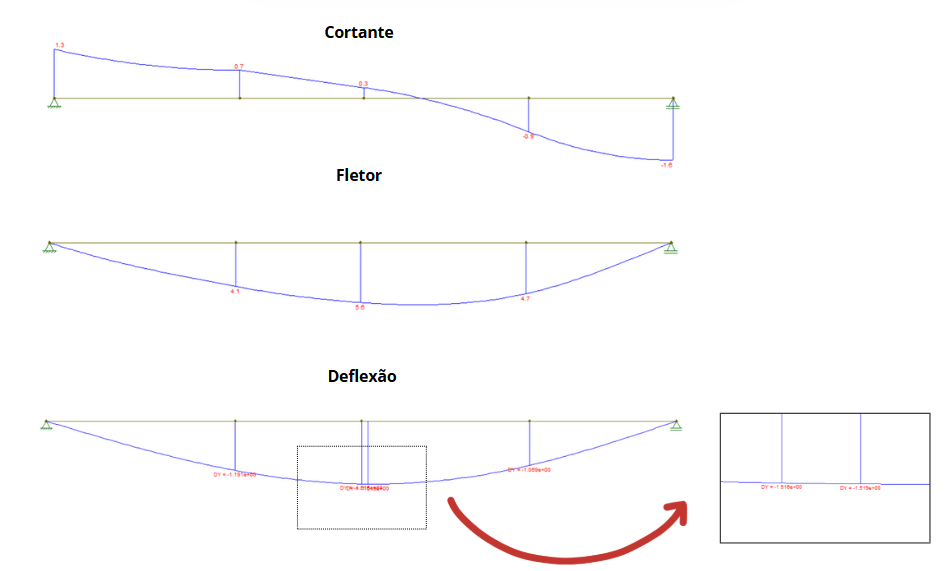

<ipython-input-2-06bc4900b488>:532: SymPyDeprecationWarning: 

non-Expr objects in a Matrix is deprecated. Matrix represents
a mathematical matrix. To represent a container of non-numeric
entities, Use a list of lists, TableForm, NumPy array, or some
other data structure instead.

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-non-expr-in-matrix
for details.

This has been deprecated since SymPy version 1.9. It
will be removed in a future version of SymPy.

  sol = sp.solve(sp.Matrix(eqs), sp.Matrix(C1s+C2s))


Matrix([
[                                                                                                                             Eq(C2, 0)],
[                                                                      Eq(4.5*C1 + C2 + C3 + 0.183710336538462, C1 + 0.116164903846154)],
[                                                                      Eq(C1 + C4 + 0.116164903846154, 4.5*C1 + C2 + 0.183710336538462)],
[                                     Eq(14.5*C1 + 3.0*C2 + 3.0*C3 + C4 + C5 + 0.910365144230769, 4.5*C1 + C2 + C3 + 0.354398798076923)],
[                                     Eq(4.5*C1 + C2 + C3 + C6 + 0.354398798076923, 14.5*C1 + 3.0*C2 + 3.0*C3 + C4 + 0.910365144230769)],
[                                    Eq(233.25*C1 + 48.5*C2 + 48.5*C3 + 15.0*C4 + 15.0*C5 + 3.5*C6 + 3.5*C7 + C8 + 17.2201317708333, 0)],
[Eq(62.5*C1 + 13.0*C2 + 13.0*C3 + 4.0*C4 + 4.0*C5 + C6 + C7 + 4.51843886217949, 14.5*C1 + 3.0*C2 + 3.0*C3 + C4 + C5 + 1.16588052884615)],
[Eq(14.5*C1 + 3.0*C2 + 3.

Matrix([
[C1],
[C3],
[C5],
[C7],
[C2],
[C4],
[C6],
[C8]])

{C1: -0.305551538461536,
 C2: 0.0,
 C3: 1.00188495192307,
 C4: -1.00188495192307,
 C5: 1.49766408653845,
 C6: -1.49766408653845,
 C7: 1.30539267628203,
 C8: -1.30539267628203}

Informações da viga:

Viga:
  Comprimento: 15
  Forças: 
  Carregamentos: 
Carregamento w1:
  start: 0
  end: 4.5
  Intensidade Inicial: -240
  Intensidade Final: 0

Carregamento w2:
  start: 4.5
  end: 7.5
  Intensidade Constante: -150

Carregamento w3:
  start: 7.5
  end: 11.5
  Intensidade Inicial: -150
  Intensidade Final: -420

Carregamento w4:
  start: 11.5
  end: 15
  Intensidade Inicial: -420
  Intensidade Final: 0

  Apoios: 
Apoio A:
  Posição: 0
  Restrições: Rx=0, Ry=1

Apoio B:
  Posição: 15
  Restrições: Rx=1, Ry=1


Reações nos apoios:
{R_Ay: 1264.33333333333, R_By: 1600.66666666667}


Compressão Máxima: 1267356490.38 Pa
Tensão Máxima: 1267356490.38 Pa




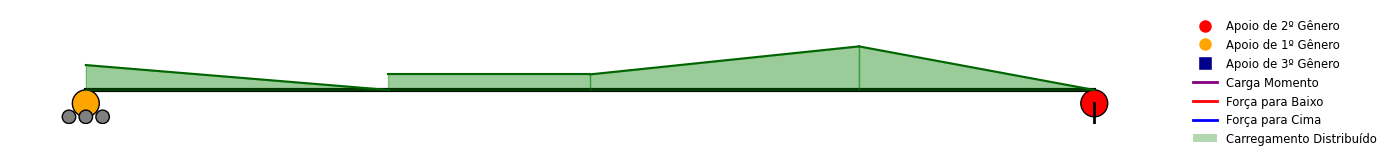

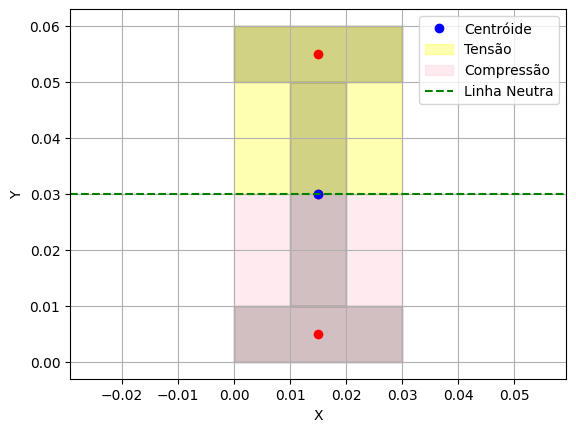

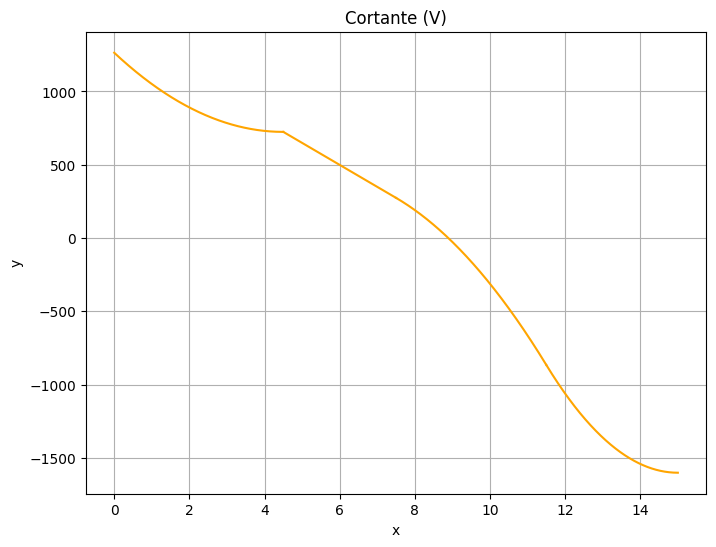

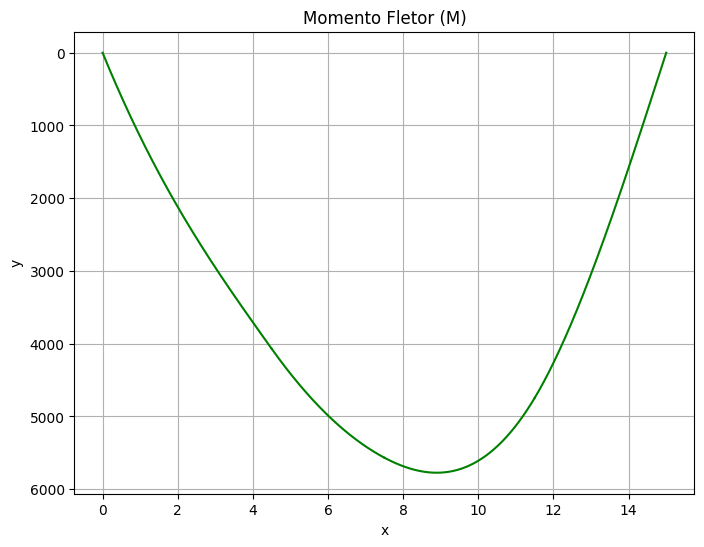

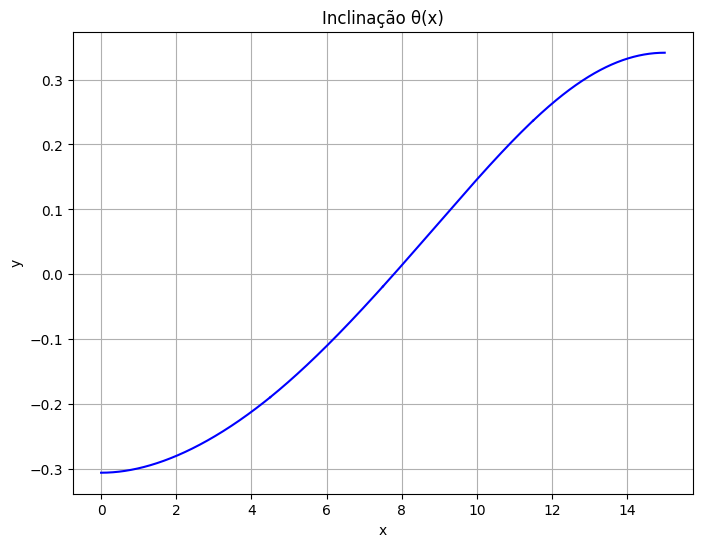

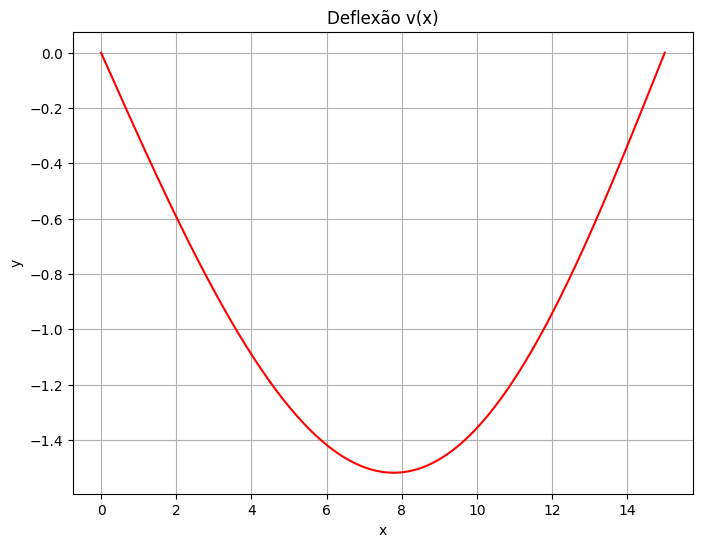

In [ ]:
# Apoios
supports = [
    Support(rx=0, ry=1, rm=0, position=0, label='A'),  # Apoio de 2º Gênero
    Support(rx=1, ry=1, rm=0, position=15, label='B'), # Apoio de 1º Gênero
]

# Carregamentos
loads = [
    LinearLoad(start=0, end=4.5, label='w1', start_intensity=-240, end_intensity=0),
    ConstantLoad(start=4.5, end=7.5, label='w2', intensity=-150),
    LinearLoad(start=7.5, end=11.5, label='w3', start_intensity=-150, end_intensity=-420),
    LinearLoad(start=11.5, end=15, label='w4', start_intensity=-420, end_intensity=0),
]

# Viga
beam = Beam(length=15, loads=loads, supports=supports, E=200e9, section=section01)

# Cálculo e Análise
beam.analyze()
beam.calculate_slope_deflection()
compression, tension, pos = beam.calculate_max_stresses()
beam.max_stress_info = (compression, tension, pos)

# Exibe informações
print("Informações da viga:")
print(beam)
beam.analyze()
print("====================")
print("Reações nos apoios:")
print(beam.support_reactions)
print("====================")
print("\n")
print(f"Compressão Máxima: {compression:.2f} Pa")
print(f"Tensão Máxima: {tension:.2f} Pa")
print("\n")

# Plot dos Resultados
draw_beam(beam)
section01.plot_section(bending_moment_sign=np.sign(compression - tension), show_stress_zones=True)

plot_analysis(beam, beam.V, 'Cortante (V)', 'orange')
plot_analysis(beam, beam.M, 'Momento Fletor (M)', 'green', invert=True)
plot_analysis(beam, beam.theta, 'Inclinação θ(x)', 'blue')
plot_analysis(beam, beam.v, 'Deflexão v(x)', 'red', invert=False)

___
# Exemplo 02

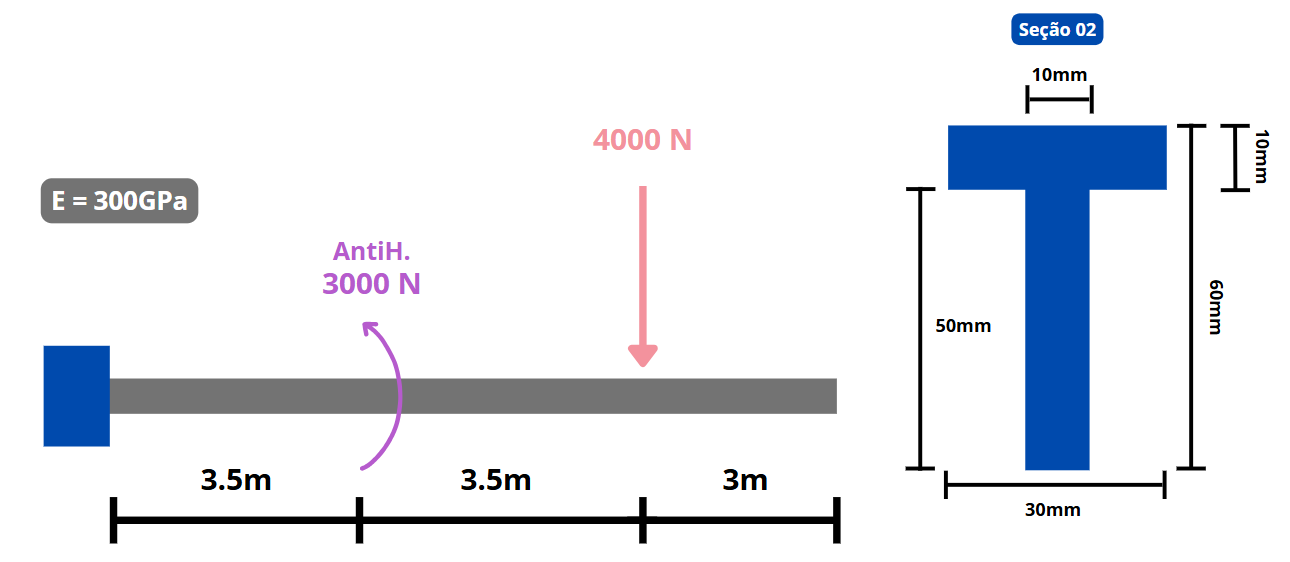

Solução pelo FTOOL:

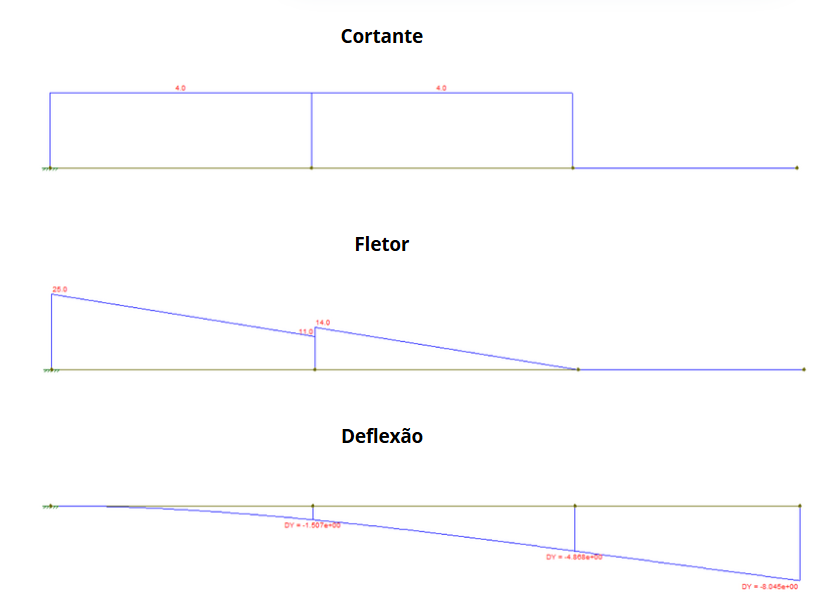

<ipython-input-2-06bc4900b488>:532: SymPyDeprecationWarning: 

non-Expr objects in a Matrix is deprecated. Matrix represents
a mathematical matrix. To represent a container of non-numeric
entities, Use a list of lists, TableForm, NumPy array, or some
other data structure instead.

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-non-expr-in-matrix
for details.

This has been deprecated since SymPy version 1.9. It
will be removed in a future version of SymPy.

  sol = sp.solve(sp.Matrix(eqs), sp.Matrix(C1s+C2s))


Matrix([
[                                                                                       Eq(C2, 0)],
[                                                                                       Eq(C1, 0)],
[                                 Eq(3.5*C1 + C2 + C3 - 1.50731215330308, C1 - 0.762481089258699)],
[                                 Eq(C1 + C4 - 0.762481089258699, 3.5*C1 + C2 - 1.50731215330308)],
[Eq(13.25*C1 + 3.5*C2 + 3.5*C3 + C4 + C5 - 6.72995461422088, 3.5*C1 + C2 + C3 - 1.80383257690368)],
[Eq(3.5*C1 + C2 + C3 + C6 - 1.80383257690368, 13.25*C1 + 3.5*C2 + 3.5*C3 + C4 - 6.72995461422088)]])

Matrix([
[C1],
[C3],
[C5],
[C2],
[C4],
[C6]])

{C1: 0.0,
 C2: 2.00825516355543e-16,
 C3: 0.744831064044381,
 C4: -0.744831064044377,
 C5: 3.80887544125062,
 C6: -3.80887544125062}

Informações da viga:

Viga:
  Comprimento: 10
  Forças: 
Força F1:
   Magnitude: -4000
   Posição: 7

  Carregamentos: 
  Apoios: 
Apoio A:
  Posição: 0
  Restrições: Rx=1, Ry=1


Reações nos apoios:
{R_Am: 25000, R_Ay: 4000}


Compressão Máxima: 3290468986.38 Pa
Tensão Máxima: 2155824508.32 Pa




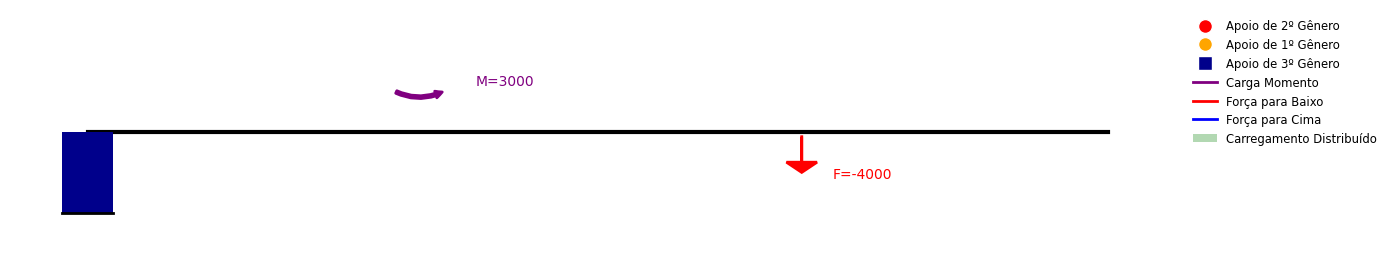

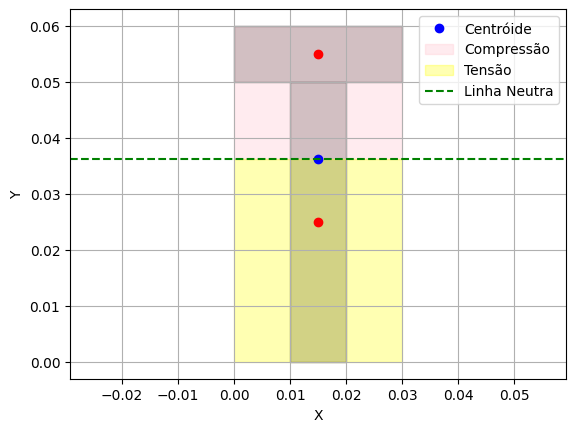

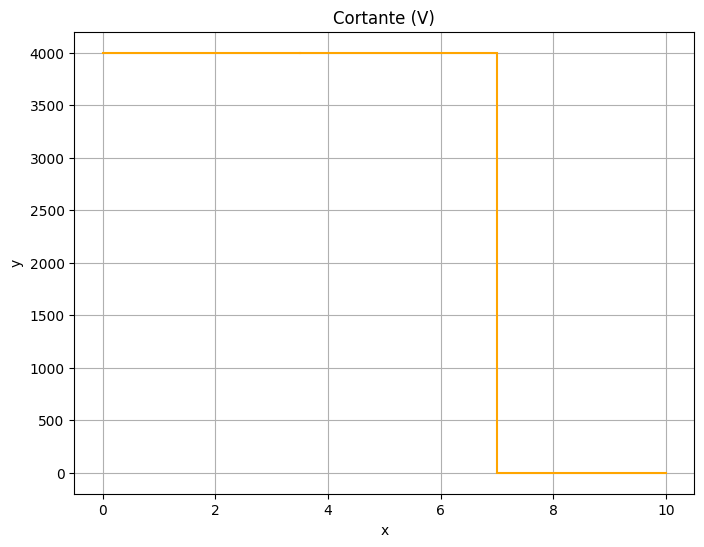

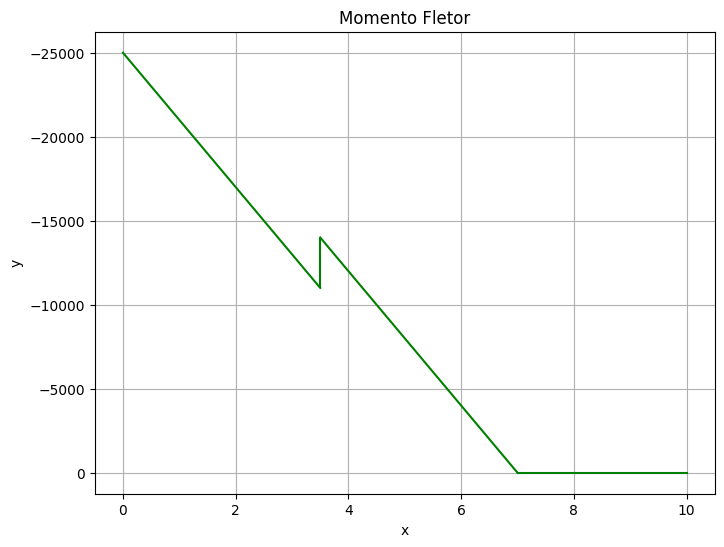

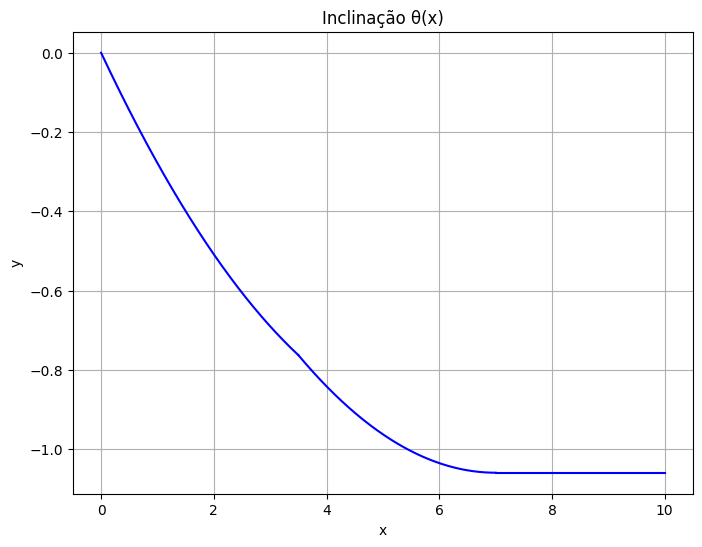

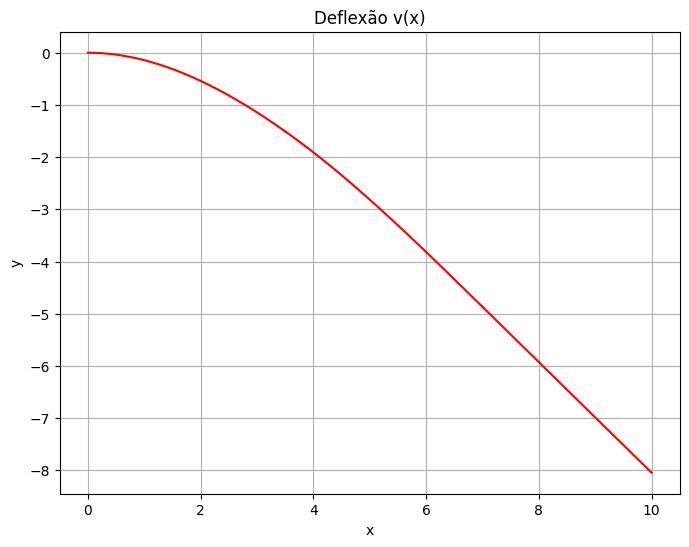

In [ ]:
# Apoios
supports = [
    Support(rx=1, ry=1, rm=1, position=0, label='A'),  # Apoio de 3º Gênero
]

# Forças
forces = [
    Force(magnitude=-4000, position=7, label='F1')
]

# Momentos
moments = [
    MomentLoad(magnitude=3000, position=3.5, label='M1')
]

# Viga fixa na esquerda e livre à direita
beam = Beam(length=10, supports=supports, forces=forces, moments=moments, E=300e9, section=section02)

# Cálculo e Análise
beam.analyze()
beam.calculate_slope_deflection()
compression, tension, pos = beam.calculate_max_stresses()
beam.max_stress_info = (compression, tension, pos)

# Exibe informações
print("Informações da viga:")
print(beam)
beam.analyze()
print("====================")
print("Reações nos apoios:")
print(beam.support_reactions)
print("====================")
print("\n")
print(f"Compressão Máxima: {compression:.2f} Pa")
print(f"Tensão Máxima: {tension:.2f} Pa")
print("\n")

# Plot dos Resultados
draw_beam(beam)
section02.plot_section(bending_moment_sign=np.sign(compression - tension), show_stress_zones=True)

plot_analysis(beam, beam.V, 'Cortante (V)', 'orange')
plot_analysis(beam, beam.M, 'Momento Fletor', 'green', invert=True)
plot_analysis(beam, beam.theta, 'Inclinação θ(x)', 'blue')
plot_analysis(beam, beam.v, 'Deflexão v(x)', 'red', invert=False)

___
# Exemplo 03

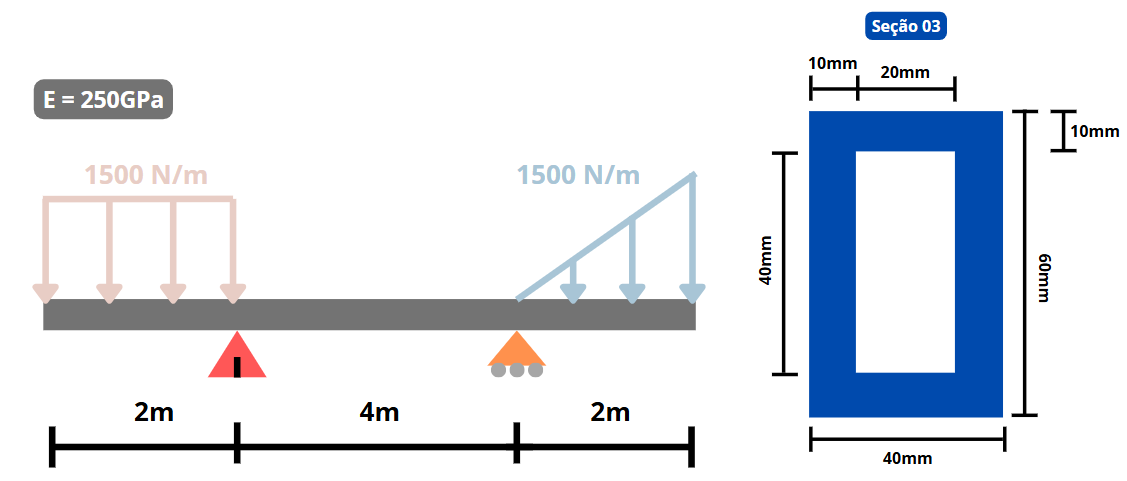

Solução pelo FTOOL:

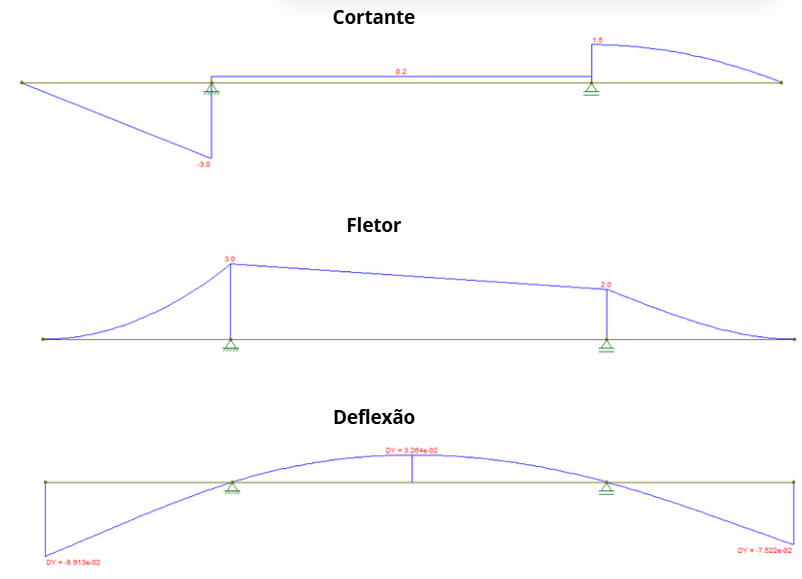

<ipython-input-2-06bc4900b488>:532: SymPyDeprecationWarning: 

non-Expr objects in a Matrix is deprecated. Matrix represents
a mathematical matrix. To represent a container of non-numeric
entities, Use a list of lists, TableForm, NumPy array, or some
other data structure instead.

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-non-expr-in-matrix
for details.

This has been deprecated since SymPy version 1.9. It
will be removed in a future version of SymPy.

  sol = sp.solve(sp.Matrix(eqs), sp.Matrix(C1s+C2s))


Matrix([
[                                                         Eq(2.0*C1 + C2 - 0.00652173913043478, 0)],
[                                                              Eq(C1 + C4 - 0.0130434782608696, 0)],
[                                         Eq(9.0*C1 + 4.0*C2 + 4.0*C3 + C4 - 0.178260869565217, 0)],
[                              Eq(2.0*C1 + C2 + C3 - 0.00652173913043478, C1 - 0.0130434782608696)],
[                                                Eq(2.0*C1 + C2 + C3 + C6 - 0.0717391304347826, 0)],
[Eq(9.0*C1 + 4.0*C2 + 4.0*C3 + C4 + C5 - 0.178260869565217, 2.0*C1 + C2 + C3 - 0.0717391304347826)]])

Matrix([
[C1],
[C3],
[C5],
[C2],
[C4],
[C6]])

{C1: 0.0478260869565217,
 C2: -0.0891304347826085,
 C3: 0.0347826086956521,
 C4: -0.0347826086956521,
 C5: -0.0304347826086953,
 C6: 0.0304347826086957}

Informações da viga:

Viga:
  Comprimento: 8
  Forças: 
  Carregamentos: 
Carregamento w1:
  start: 0
  end: 2
  Intensidade Constante: -1500

Carregamento w2:
  start: 6
  end: 8
  Intensidade Inicial: 0
  Intensidade Final: -1500

  Apoios: 
Apoio A:
  Posição: 2
  Restrições: Rx=1, Ry=1

Apoio B:
  Posição: 6
  Restrições: Rx=0, Ry=1


Reações nos apoios:
{R_Ay: 3250.00000000000, R_By: 1250.00000000000}


Compressão Máxima: 2641304347.83 Pa
Tensão Máxima: 2641304347.83 Pa




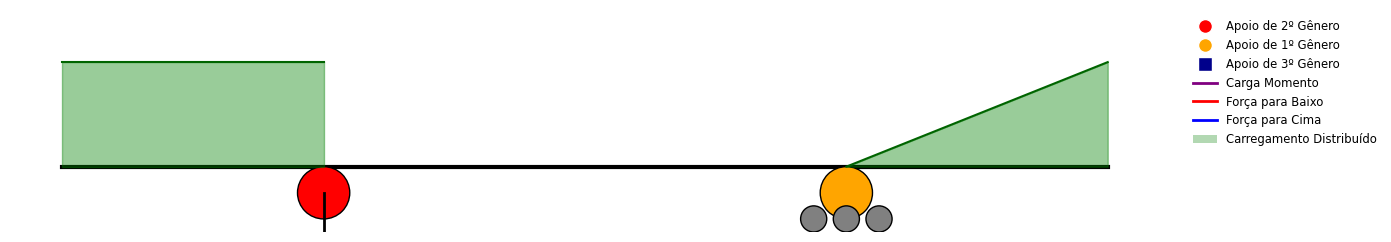

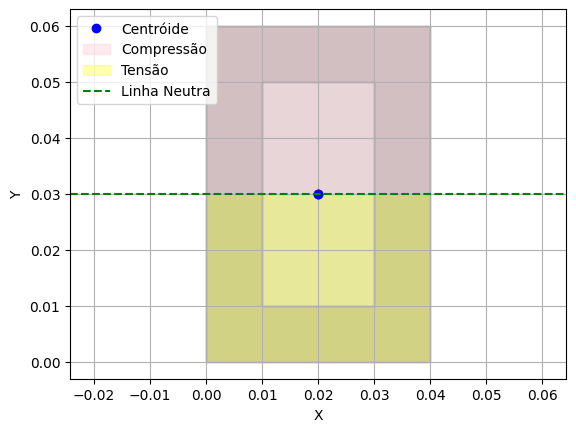

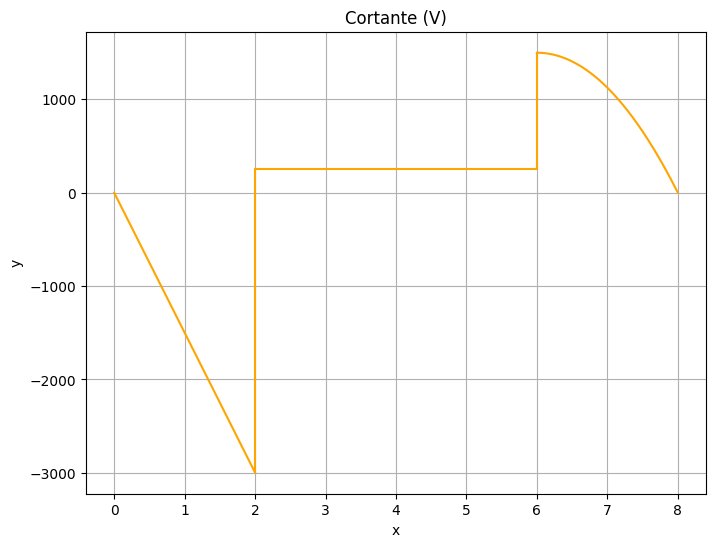

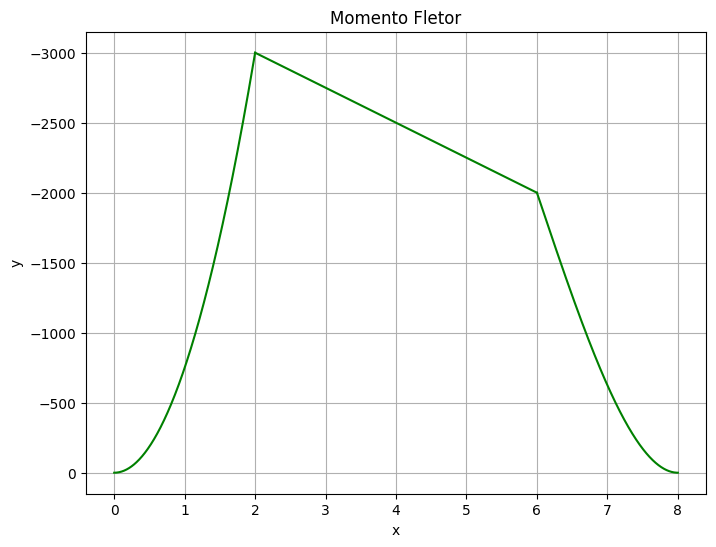

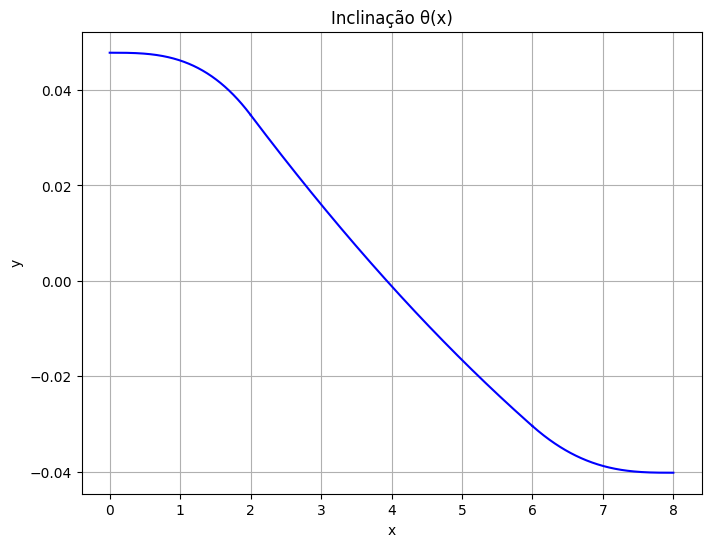

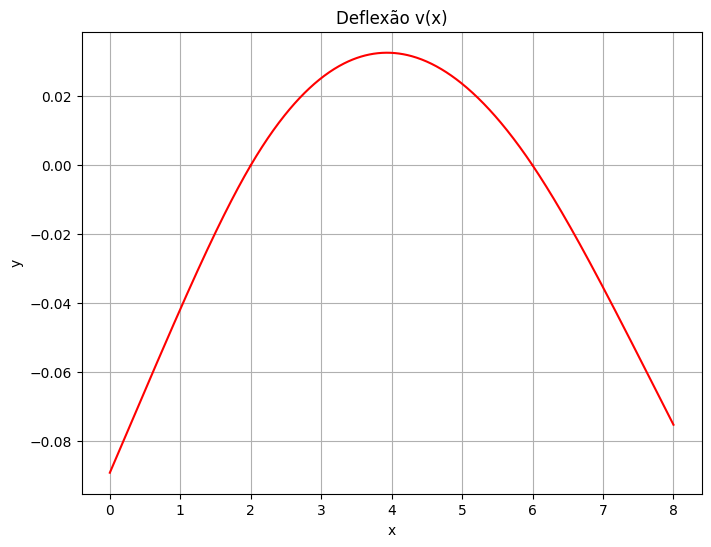

In [ ]:
# Apoios
supports=[
    Support(rx=1, ry=1, rm=0, position=2, label='A'),
    Support(rx=0, ry=1, rm=0, position=6, label='B')
]

# Carregamentos
loads=[
    ConstantLoad(start=0, end=2, label='w1', intensity=-1500),
    LinearLoad(start=6, end=8, label='w2', start_intensity=0, end_intensity=-1500)
]

# Viga
beam = Beam(length=8, supports=supports, loads=loads, E=250e9, section=section03)

# Cálculo e Análise
beam.analyze()
beam.calculate_slope_deflection()
compression, tension, pos = beam.calculate_max_stresses()
beam.max_stress_info = (compression, tension, pos)

# Exibe informações
print("Informações da viga:")
print(beam)
beam.analyze()
print("====================")
print("Reações nos apoios:")
print(beam.support_reactions)
print("====================")
print("\n")
print(f"Compressão Máxima: {compression:.2f} Pa")
print(f"Tensão Máxima: {tension:.2f} Pa")
print("\n")

# Plot dos Resultados
draw_beam(beam)
section03.plot_section(bending_moment_sign=np.sign(compression - tension), show_stress_zones=True)

plot_analysis(beam, beam.V, 'Cortante (V)', 'orange')
plot_analysis(beam, beam.M, 'Momento Fletor', 'green', invert=True)
plot_analysis(beam, beam.theta, 'Inclinação θ(x)', 'blue')
plot_analysis(beam, beam.v, 'Deflexão v(x)', 'red', invert=False)

___
# Exemplo 04

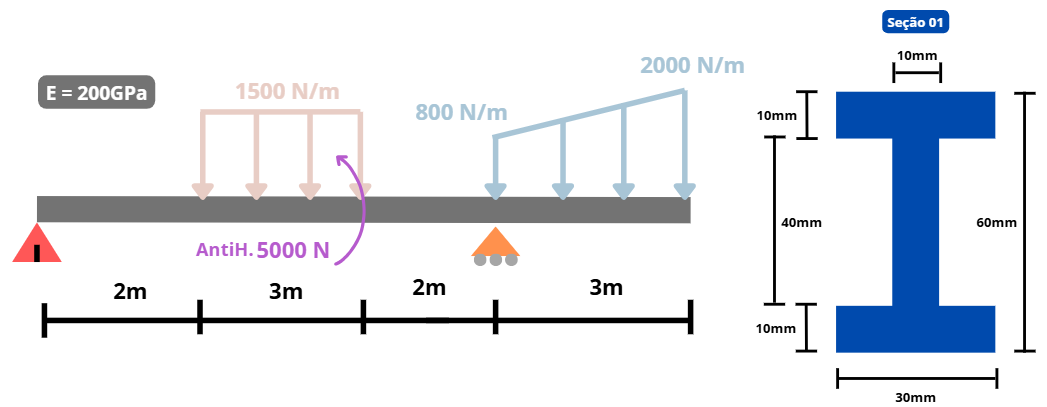

Solução pelo FTOOL:

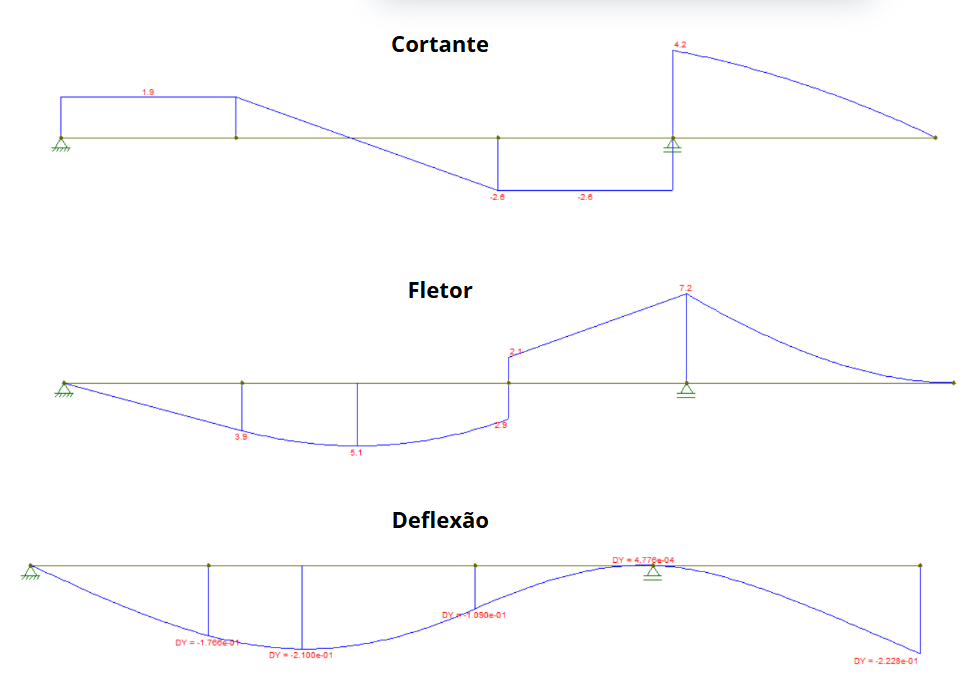

<ipython-input-2-06bc4900b488>:532: SymPyDeprecationWarning: 

non-Expr objects in a Matrix is deprecated. Matrix represents
a mathematical matrix. To represent a container of non-numeric
entities, Use a list of lists, TableForm, NumPy array, or some
other data structure instead.

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-non-expr-in-matrix
for details.

This has been deprecated since SymPy version 1.9. It
will be removed in a future version of SymPy.

  sol = sp.solve(sp.Matrix(eqs), sp.Matrix(C1s+C2s))


Matrix([
[                                                                                                                            Eq(C2, 0)],
[                                                                   Eq(2.0*C1 + C2 + C3 + 0.0297802197802198, C1 + 0.0446703296703297)],
[                                                                   Eq(C1 + C4 + 0.0446703296703297, 2.0*C1 + C2 + 0.0297802197802198)],
[                                                          Eq(16.0*C1 + 7.0*C2 + 7.0*C3 + 2.0*C4 + 2.0*C5 + C6 + 0.853406593406593, 0)],
[                                     Eq(7.0*C1 + 3.0*C2 + 3.0*C3 + C4 + C5 + 0.377122252747253, 2.0*C1 + C2 + C3 + 0.186414835164835)],
[                                     Eq(2.0*C1 + C2 + C3 + C6 + 0.186414835164835, 7.0*C1 + 3.0*C2 + 3.0*C3 + C4 + 0.377122252747253)],
[                                                                   Eq(7.0*C1 + 3.0*C2 + 3.0*C3 + C4 + C5 + C8 + 0.270144230769231, 0)],
[Eq(16.0*C1 + 7.0*C2 + 7.0*C3 + 

Matrix([
[C1],
[C3],
[C5],
[C7],
[C2],
[C4],
[C6],
[C8]])

{C1: -0.103179945054945,
 C2: 0.0,
 C3: 0.118070054945055,
 C4: -0.118070054945055,
 C5: 0.207122252747253,
 C6: -0.207122252747253,
 C7: -0.00885302197802196,
 C8: 0.00885302197802164}

Informações da viga:

Viga:
  Comprimento: 10
  Forças: 
  Carregamentos: 
Carregamento w1:
  start: 2
  end: 5
  Intensidade Constante: -1500

Carregamento w2:
  start: 7
  end: 10
  Intensidade Inicial: -800
  Intensidade Final: -2000

  Apoios: 
Apoio A:
  Posição: 0
  Restrições: Rx=1, Ry=1

Apoio B:
  Posição: 7
  Restrições: Rx=0, Ry=1


Reações nos apoios:
{R_Ay: 1935.71428571429, R_By: 6764.28571428571}


Compressão Máxima: 4975384615.38 Pa
Tensão Máxima: 4975384615.38 Pa




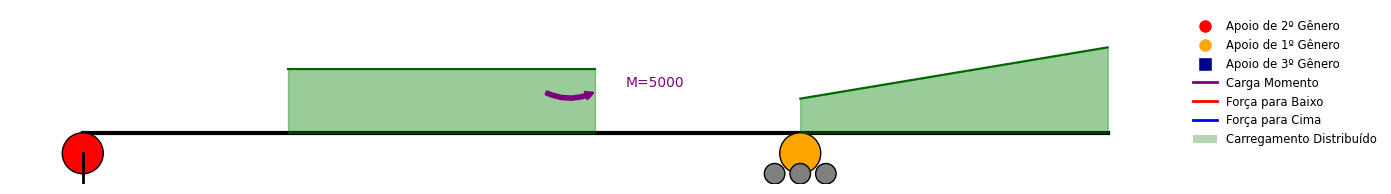

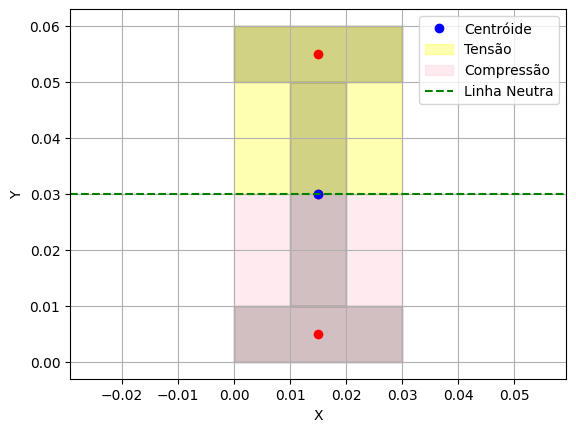

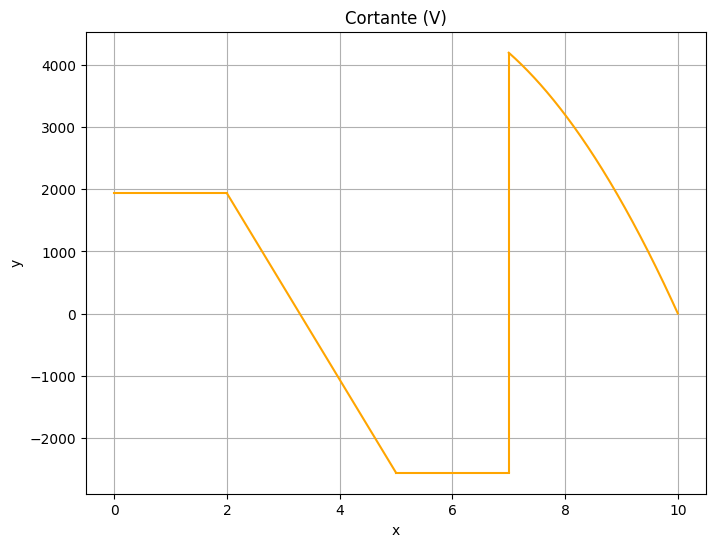

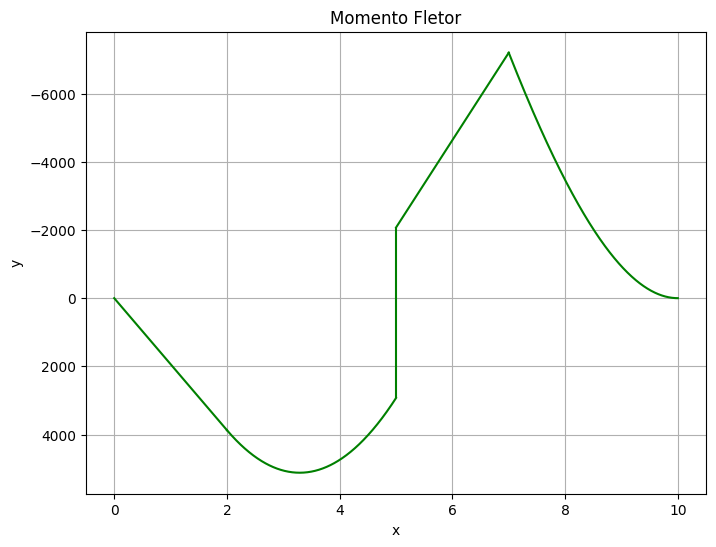

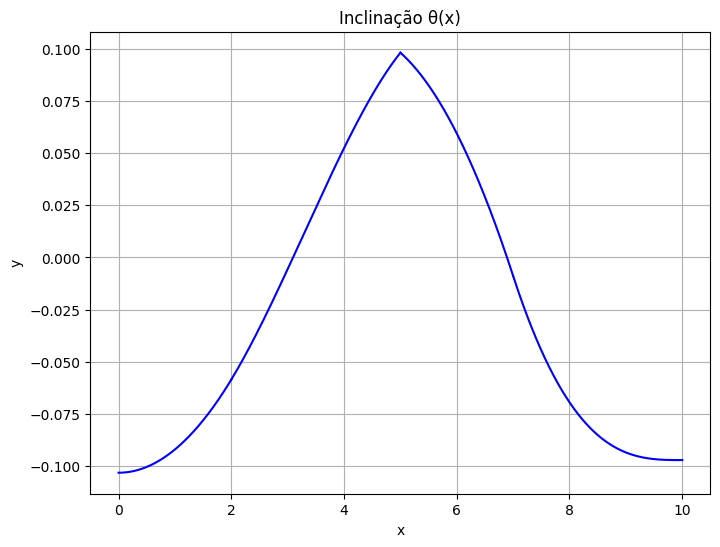

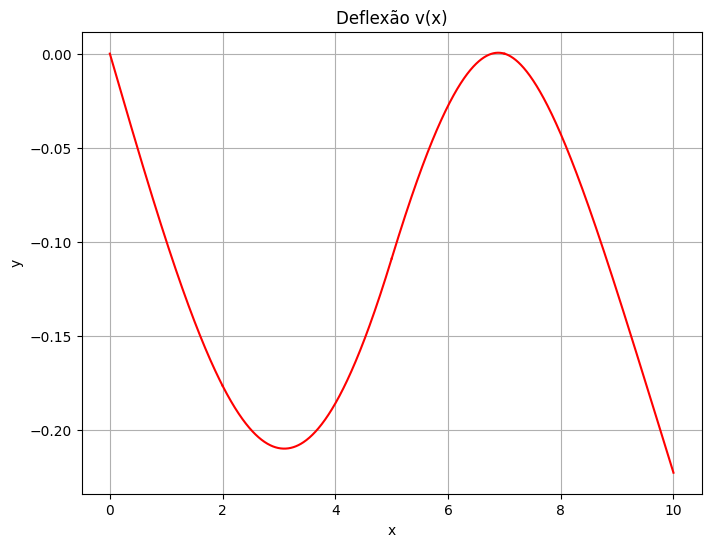

In [ ]:
# Apoios
supports = [
    Support(rx=1, ry=1, rm=0, position=0, label='A'),
    Support(rx=0, ry=1, rm=0, position=7, label='B')
]

# Carregamentos
loads=[
    ConstantLoad(start=2, end=5, label='w1', intensity=-1500),
    LinearLoad(start=7, end=10, label='w2', start_intensity=-800, end_intensity=-2000)
]

# Carga Momento
moments=[
    MomentLoad(magnitude=5000, position=5, label='M1')
]

# Viga
beam = Beam(length=10,supports=supports, loads=loads, moments=moments, E=200e9, section=section01)

# Cálculo e Análise
beam.analyze()
beam.calculate_slope_deflection()
compression, tension, pos = beam.calculate_max_stresses()
beam.max_stress_info = (compression, tension, pos)

# Exibe informações
print("Informações da viga:")
print(beam)
beam.analyze()
print("====================")
print("Reações nos apoios:")
print(beam.support_reactions)
print("====================")
print("\n")
print(f"Compressão Máxima: {compression:.2f} Pa")
print(f"Tensão Máxima: {tension:.2f} Pa")
print("\n")

# Plot dos Resultados
draw_beam(beam)
section01.plot_section(bending_moment_sign=np.sign(compression - tension), show_stress_zones=True)

plot_analysis(beam, beam.V, 'Cortante (V)', 'orange')
plot_analysis(beam, beam.M, 'Momento Fletor', 'green', invert=True)
plot_analysis(beam, beam.theta, 'Inclinação θ(x)', 'blue')
plot_analysis(beam, beam.v, 'Deflexão v(x)', 'red', invert=False)

___
# Exemplo 05

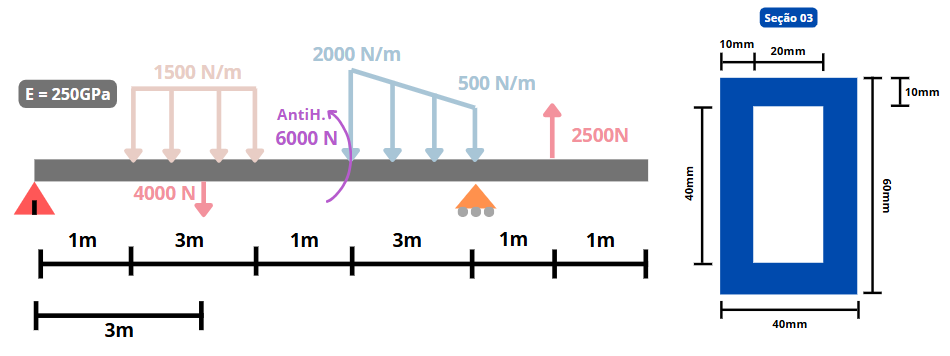

Solução pelo FTOOL:

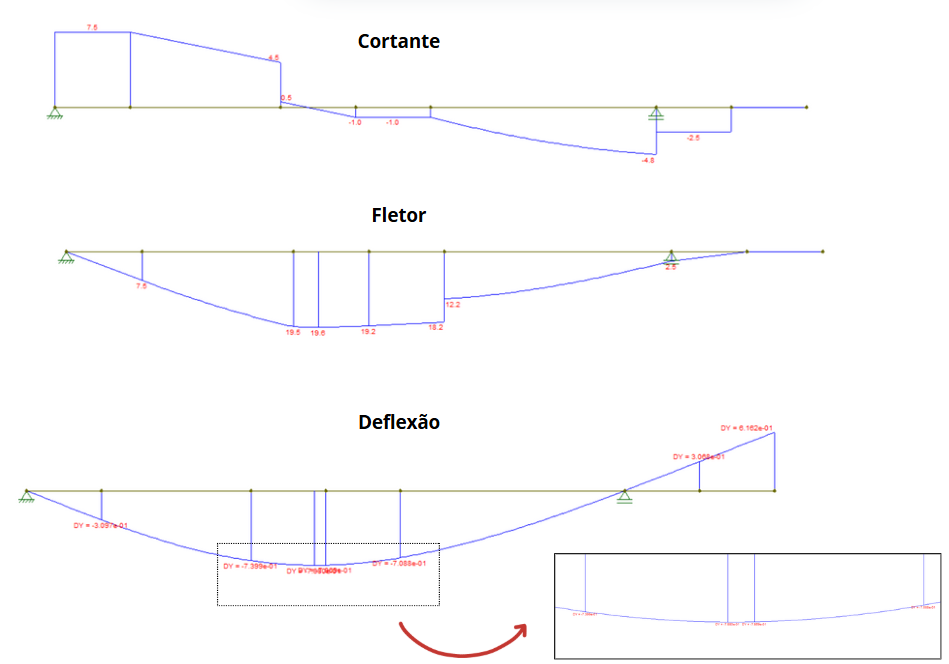

<ipython-input-2-06bc4900b488>:532: SymPyDeprecationWarning: 

non-Expr objects in a Matrix is deprecated. Matrix represents
a mathematical matrix. To represent a container of non-numeric
entities, Use a list of lists, TableForm, NumPy array, or some
other data structure instead.

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-non-expr-in-matrix
for details.

This has been deprecated since SymPy version 1.9. It
will be removed in a future version of SymPy.

  sol = sp.solve(sp.Matrix(eqs), sp.Matrix(C1s+C2s))


Matrix([
[                                                                                                                                                                                                                                                 Eq(C2, 0)],
[                                                                                                                                                                                       Eq(1.0*C1 + C2 + C3 + 0.00815217391304348, C1 + 0.0244565217391304)],
[                                                                                                                                                                                       Eq(C1 + C4 + 0.0244565217391304, 1.0*C1 + C2 + 0.00815217391304348)],
[                                                                                                                                                          Eq(3.0*C1 + 2.0*C2 + 2.0*C3 + C4 + C5 + 0.197282608695652, 1.0*C1 + C2 + C

Matrix([
[ C1],
[ C3],
[ C5],
[ C7],
[ C9],
[C11],
[C13],
[ C2],
[ C4],
[ C6],
[ C8],
[C10],
[C12],
[C14]])

{C1: -0.317826086956522,
 C10: -0.847527173913046,
 C11: 0.301331521739132,
 C12: -0.301331521739131,
 C13: 0.00271739130434855,
 C14: -0.00271739130434855,
 C2: 0.0,
 C3: 0.0163043478260878,
 C4: -0.0163043478260870,
 C5: 0.629130434782611,
 C6: -0.629130434782610,
 C7: 0.803342391304350,
 C8: -0.803342391304350,
 C9: 0.847527173913046}

Informações da viga:

Viga:
  Comprimento: 10
  Forças: 
Força F1:
   Magnitude: -4000
   Posição: 3

Força F2:
   Magnitude: 2500
   Posição: 9

  Carregamentos: 
Carregamento w1:
  start: 1
  end: 4
  Intensidade Constante: -1500

Carregamento w2:
  start: 5
  end: 8
  Intensidade Inicial: -2000
  Intensidade Final: -500

  Apoios: 
Apoio A:
  Posição: 0
  Restrições: Rx=1, Ry=1

Apoio B:
  Posição: 8
  Restrições: Rx=0, Ry=1


Reações nos apoios:
{R_Ay: 7500.00000000000, R_By: 2250.00000000000}


Compressão Máxima: 1137228260.87 Pa
Tensão Máxima: 1137228260.87 Pa




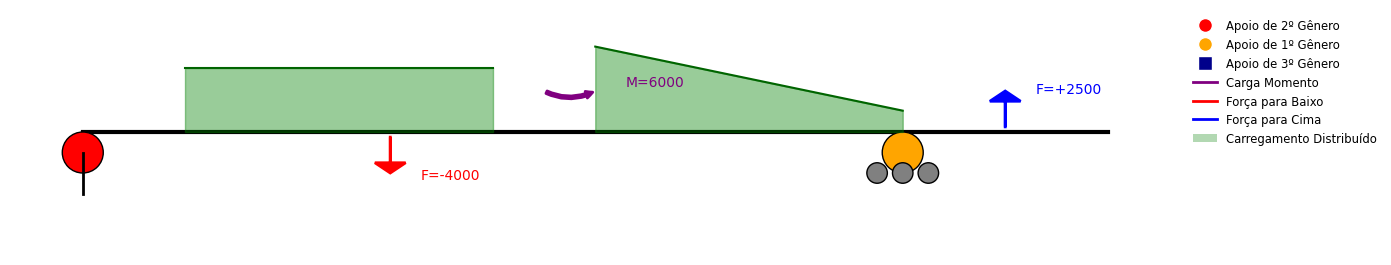

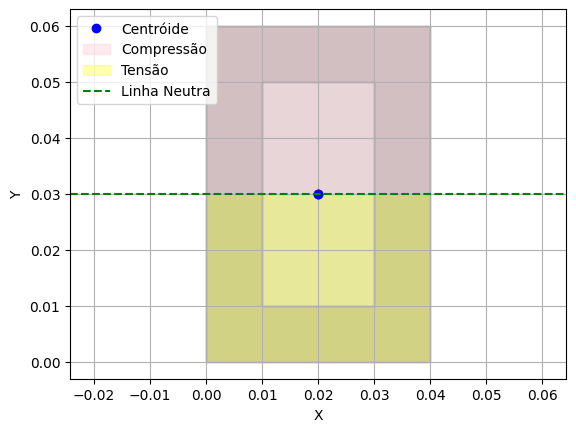

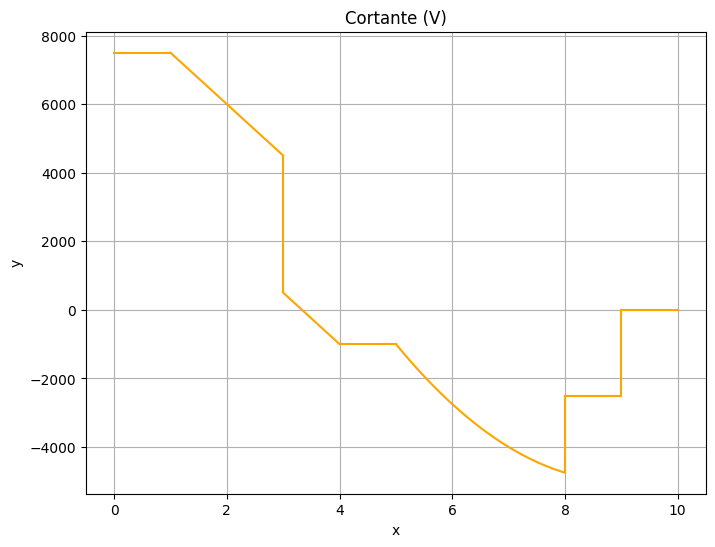

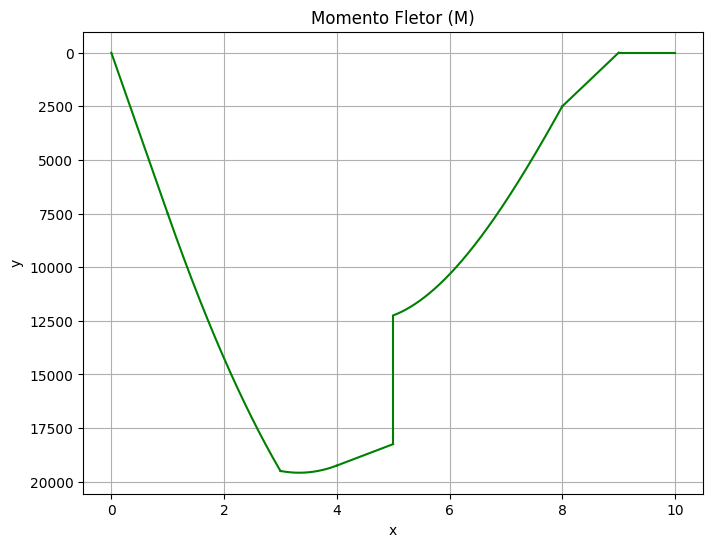

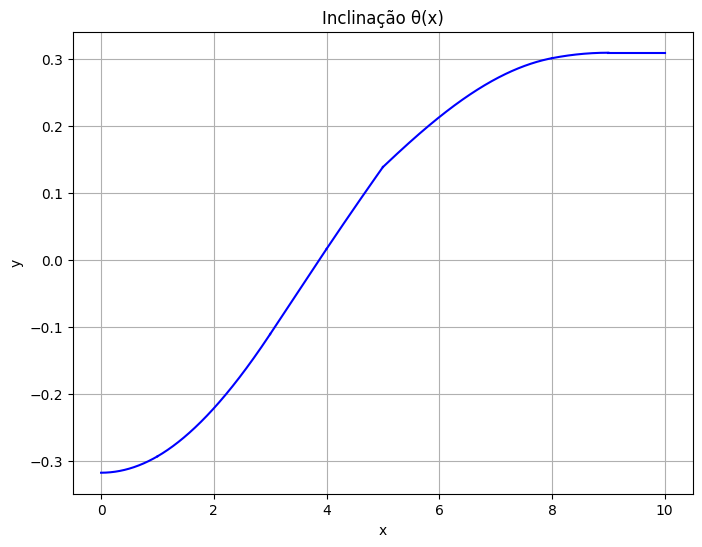

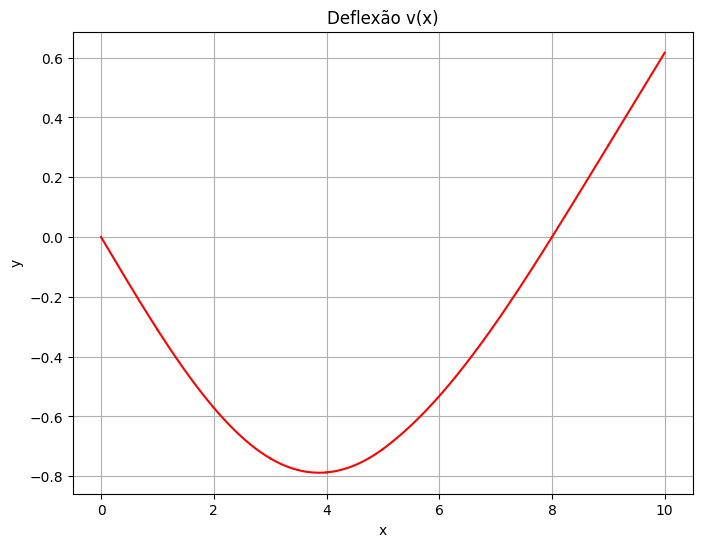

In [ ]:
# Apoios
supports = [
    Support(rx=1, ry=1, rm=0, position=0, label='A'),
    Support(rx=0, ry=1, rm=0, position=8, label='B')
]

# Carregamentos
loads = [
    ConstantLoad(start=1, end=4, label='w1', intensity=-1500),
    LinearLoad(start=5, end=8, label='w2', start_intensity=-2000, end_intensity=-500),
]

# Forças
forces = [
    Force(magnitude=-4000, position=3, label='F1'),
    Force(magnitude=2500, position=9, label='F2')
]

# Carga Momento
moments = [
    MomentLoad(magnitude=6000, position=5, label='M1')
]

beam = Beam(length=10, supports=supports, loads=loads, forces=forces, moments=moments, E=250e9, section=section03)

# Cálculo e Análise
beam.analyze()
beam.calculate_slope_deflection()
compression, tension, pos = beam.calculate_max_stresses()
beam.max_stress_info = (compression, tension, pos)

# Exibe informações
print("Informações da viga:")
print(beam)
beam.analyze()
print("====================")
print("Reações nos apoios:")
print(beam.support_reactions)
print("====================")
print("\n")
print(f"Compressão Máxima: {compression:.2f} Pa")
print(f"Tensão Máxima: {tension:.2f} Pa")
print("\n")

# Plot dos Resultados
draw_beam(beam)
section03.plot_section(bending_moment_sign=np.sign(compression - tension), show_stress_zones=True)

plot_analysis(beam, beam.V, 'Cortante (V)', 'orange')
plot_analysis(beam, beam.M, 'Momento Fletor (M)', 'green', invert=True)
plot_analysis(beam, beam.theta, 'Inclinação θ(x)', 'blue')
plot_analysis(beam, beam.v, 'Deflexão v(x)', 'red', invert=False)